In [1]:
import cbpro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import sleep, time
import ta
from datetime import datetime, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

In [2]:
import json

#dicto = {"api_public": 
#         ,"api_secret": "
#         ,"passphrase": }
#with open("config_trading_bot.json", "w") as f:
#    f.write(json.dumps(dicto))

with open("config_trading_bot.json") as json_data_file:
    config = json.load(json_data_file)
client = cbpro.AuthenticatedClient(config["api_public"], config["api_secret"], config["passphrase"])

In [3]:
for order in client.get_orders():
    print(order)

## Utility functions

In [4]:
def get_n_orders(client):
    counter = 0
    for e in client.get_orders():
        counter +=1
    return counter
    

In [5]:
def get_balance(client):
    for account in client.get_accounts():
        if account["currency"] == "EUR":
            balance = account["balance"]
            break

## DATA RETRIEVAL AND CLEANING


In [6]:
def getminutedata(symbol, interval_min=1, lookback=24*60):
    '''
    Method to obtain minute data from the Coinbase Pro API
    
    Parameters
    ----------
    
    symbol : str
         Symbol of the currency, e.g., "BTC-EUR", "DOT-EUR", "BTC-USD", "DOT-USD"
    
    interval_min : int
            The interval in minutes between the retrieved timestamps, can only be in the following range [1, 5, 15, 60, 360, 1440]
    
    lookback : int
        The number of minutes to lookback starting from the current timestamp
        
    Returns
    -------
    Pandas Dataframe
        a dataframe with the trade data

    '''
    
    MAX_REQUESTS = 300  # can only request 300 timestamps each time
    interval_sec = interval_min*60  # interval in seconds
    
    end = pd.to_datetime(client.get_time()["epoch"], unit ="s")  # end date
    start = end - timedelta(minutes=lookback)  # start date
    current_start = start
    
    try:
        # one request can only retrieve up to 300 timestamps: use for loop to obtain the desired range with multiple requests
        dataframes = []
        n_timestamps = int(lookback/interval_min)
        delta = timedelta(minutes=min(lookback, MAX_REQUESTS)*interval_min)  # time between each timestamp
        for i in range(int(n_timestamps/MAX_REQUESTS)):    
            current_end = current_start + delta
            dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))[::-1])
            current_start = current_end
        dataframes.append(pd.DataFrame(client.get_product_historic_rates(symbol, current_start.isoformat(), end, interval_sec))[::-1])
        df = pd.concat(dataframes)
    except:
        print("ERROR:")
        print(client.get_product_historic_rates(symbol, current_start.isoformat(), current_end.isoformat(), interval_sec))  # should print what error we got
        
    # clean dataframe
    df.columns = ["Time", "Low", "High", "Open", "Close", "Volume"]
    df = df.astype(float)
    df = df.set_index("Time")
    df.index = pd.to_datetime(df.index, unit ="s")
    
    # add some measures
    df['RSI'] = ta.momentum.rsi(df.Close, window=10)
    df['SMA200'] = ta.trend.sma_indicator(df.Close, window=200)
    df['EMA200'] = ta.trend.ema_indicator(df.Close, window=200)
    df['SMA100'] = ta.trend.sma_indicator(df.Close, window=100)
    df['EMA100'] = ta.trend.ema_indicator(df.Close, window=100)
    df['SMA50'] = ta.trend.sma_indicator(df.Close, window=50)
    df['EMA50'] = ta.trend.ema_indicator(df.Close, window=50)
    df['SMA60'] = ta.trend.sma_indicator(df.Close, window=60)
    df['EMA60'] = ta.trend.ema_indicator(df.Close, window=60)

    df["pct change"] =df.Open.pct_change()+1
    df["CUM_RETURNS_50"] = (df.Open.pct_change()+1).rolling(50).apply(np.prod)
    df["CUM_RETURNS_60"] = (df.Open.pct_change()+1).rolling(60).apply(np.prod)
    df["CUM_RETURNS_100"] = (df.Open.pct_change()+1).rolling(100).apply(np.prod)

    return df

    
    

## Strategies

The function for each strategy should be able to take a **pandas dataframe** as input and returns **"BUY", "SELL", "NO TRADE"** to indicate whether and what kind of trade will happen.

In [7]:
def RSI_SMA_return_strategy(row, entried = False, max_profit=1.010, stop_loss=0.990):
    signal = (row.Close > row.SMA60) & (row.RSI < 40) & (row.CUM_RETURNS_60 > 1.000)  # RSI SMA strategy
    
    # not entried yet so try to buy
    if not entried:
        if signal:
            return "BUY" # buy next open
        
    # entried into a buy position so try to sell at a good price
    if entried:
        price_change_since_buying = row.Open/row.last_buying_price
        if row.RSI > 70:
            print("rsi")
            return "SELL" # sell next open
        elif price_change_since_buying > max_profit:
            print("max profit")
            return "SELL"
        elif price_change_since_buying < stop_loss:
            print("stop loss")
            return "SELL"

    return "NO TRADE"  # No trade



In [8]:
def RSI_SMA_strategy(row, entried = False, stop_loss=0.985):
    signal = (row.Close > row.EMA50) & (row.RSI < 40)  # RSI SMA strategy
    
    # not entried yet so try to buy
    if not entried:
        if signal:
            return "BUY" # buy next open
        
    # entried into a buy position so try to sell at a good price
    if entried:
        price_change_since_buying = row.Open/row.last_buying_price
        if row.RSI > 50:
            return "SELL" # sell next open

        elif price_change_since_buying < stop_loss:
            return "SELL"

    return "NO TRADE"  # No trade

    

## Backtesting

In [9]:
def backtest(strategy, df, capital=1000):
    '''
    Backtest your strategy with this function
    
    Parameters
    ----------
    
    strategy : func
        function that returns "BUY", "SELL", "NO TRADE"
        
    df : pandas dataframe
        dataframe containing the trading data
    
    Returns
    -------
    Pandas dataframe
        dataframe containing the buying/selling dates with the profits, returns and open prices
    
    '''
    
    buying_dates = []
    buying_open_prices = []
    selling_dates = []
    selling_open_prices = []
    capital_list = [capital]
    crypto_list = []  # list of the number of crypto that is bought with the current capital
    entried = False
    
    # check per row whether we want to buy or sell the stock
    for i in range(len(df)-1):
        row = df.iloc[i].copy()
        next_row = df.iloc[i+1].copy()
        if entried:
            row["last_buying_price"] = buying_open_prices[-1]
        
        action = strategy(row, entried)
        timestamp = next_row.name
        
        if action == "BUY" and capital > 0 and entried == False:
            entried = True
            buying_dates.append(timestamp)
            buying_open_prices.append(next_row.Open)
            crypto_list.append(capital_list[-1]/next_row.Open)
        elif action == "SELL" and entried == True:
            entried = False
            selling_dates.append(timestamp)
            selling_open_prices.append(next_row.Open)
            capital_list.append(crypto_list[-1]*next_row.Open)
    
    # if we have more buying dates, then it means that the last selling date has not taken place yet
    if len(buying_dates) > len(selling_dates):
        buying_dates = buying_dates[:-1]
        buying_open_prices = buying_open_prices[:-1]
        
    actual_trades = pd.DataFrame({"buying_date": buying_dates, "selling_date": selling_dates, "buying_open_price": buying_open_prices, "selling_open_price": selling_open_prices})
    
    
        
    # plot results
    plt.style.use("ggplot")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    ax=axes[0,0]
    ax2=axes[1,0]
    ax3 = axes[0,1]
    
    #ax1
    df.plot(kind="line", y="Open", ax=ax, linewidth=0.7, alpha =0.5)
    #df.plot(kind="line", y="SMA200", c="orange", alpha =1, ax=ax, label = "SMA200")
    #df.plot(kind="line", y="EMA200", c="purple", alpha =1, ax=ax, label = "EMA200")
    #df.plot(kind="line", y="SMA50", alpha =1, ax=ax, label = "SMA50")
    #df.plot(kind="line", y="EMA100", alpha =1, ax=ax, label = "EMA100")
    #df.plot(kind="line", y="SMA100", alpha =1, ax=ax, label = "SMA100")
    #df.plot(kind="line", y="EMA50", alpha =1, ax=ax, label = "EMA50")
    
    df.plot(kind="line", y="SMA60", alpha =0.5, ax=ax, label = "SMA60")
    df.plot(kind="line", y="EMA60", c ="purple", alpha =0.5, ax=ax, label = "EMA60")
    actual_trades.plot(kind="scatter", s=20, c="red", x="buying_date", y="buying_open_price", ax=ax, label="BUY", alpha=1)
    actual_trades.plot(kind="scatter", s=20, c="green", x="selling_date", y="selling_open_price", ax=ax, label="SELL", alpha=1)
    ax.set_xlabel("time")
    ax.set_ylabel("price")
    #ax2
    df.plot(kind="line", y="RSI", linewidth=0.5, alpha =1, ax=ax2, label = "RSI")
    ax2.set_ylim((0,100))
    ax2.axhline(50, c="black")
    ax2.axhline(30, c="black")
    ax2.set_xlabel("time")
    #ax3
    df.plot(kind="line", y="pct change", c="orange", linewidth=0.7, alpha =1, ax=ax3, label = "pct change")
    #df.plot(kind="line", y="CUM_RETURNS_50", c="purple", linewidth=1, alpha = 0.7, ax=ax3, label = "CUM_RETURNS_50")
    df.plot(kind="line", y="CUM_RETURNS_60", c="green", linewidth=1, alpha = 0.7, ax=ax3, label = "CUM_RETURNS_60")
    ax3.set_xlabel("time")


    #myFmt = mdates.DateFormatter(' %H:%M:')

    #ax.xaxis.set_major_formatter(myFmt)



    plt.gcf().autofmt_xdate()
    
    # if there are actual trades retrieve the performance measures
    if len(actual_trades) > 0:
        # performance measures
        profits = df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values
        winning_rate = np.sum([profits>0])/len(profits)
        returns = (df.loc[actual_trades.selling_date].Open.values - df.loc[actual_trades.buying_date].Open.values)/df.loc[actual_trades.buying_date].Open.values

        # adding performance measures to dataframe
        actual_trades["profit"] = profits
        actual_trades["return"] = returns

        # print results
        print(capital_list)
        print(crypto_list)
        print("ACTUAL TRADES:")
        print(actual_trades)
        print("\n")
        print("profit: %.2f" % sum(profits)) 
        print("average returns:  %.6f" % (sum(returns)/max(1, len(returns))))
        print("returns:  %.6f" % (np.prod(returns+1)-1))
        print("winning rate:  %.2f" % (winning_rate))
        print("\n")
        print("starting capital: %.2f" % capital)
        print("end capital: %.2f" % capital_list[-1])
        print("return: %.6f" % ((capital_list[-1]-capital)/capital))
        return actual_trades
    else:

        print("NO TRADES HAVE TAKEN PLACE")
        return None

[1000, 1000.7196384890384, 1002.3546118639682, 1002.2401695255984]
[0.026350731931105483, 0.02646872875068672, 0.02649128203006749]
ACTUAL TRADES:
          buying_date        selling_date  buying_open_price  selling_open_price  profit    return
0 2022-01-16 07:57:00 2022-01-16 08:01:00           37949.61            37976.92   27.31  0.000720
1 2022-01-16 14:18:00 2022-01-16 14:22:00           37807.62            37869.39   61.77  0.001634
2 2022-01-16 22:47:00 2022-01-16 22:56:00           37837.15            37832.83   -4.32 -0.000114


profit: 84.76
average returns:  0.000746
returns:  0.002240
winning rate:  0.67


starting capital: 1000.00
end capital: 1002.24
return: 0.002240


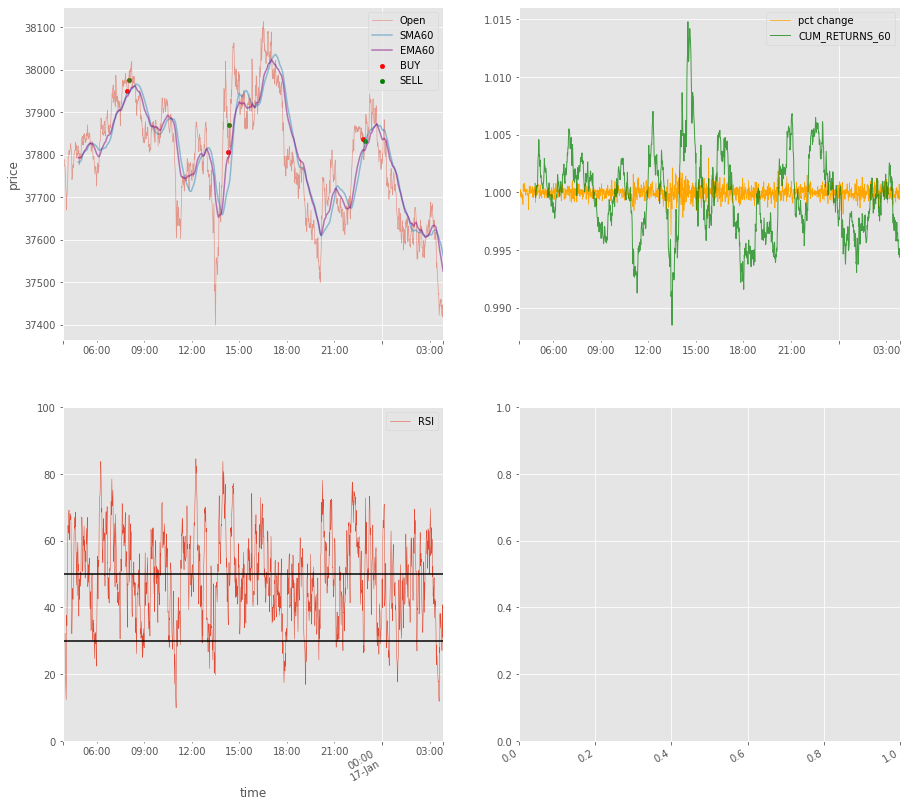

In [10]:
df = getminutedata("BTC-EUR", interval_min=1, lookback=60*24)
results = backtest(RSI_SMA_strategy, df)

rsi
rsi
rsi
stop loss
rsi
rsi
[1000, 999.5881380599169, 997.1040137545285, 1002.4864990357273, 992.8595515659409, 994.1611368914291, 995.6908520361961]
[0.026350731931105483, 0.026384750986600182, 0.026373096580914863, 0.026370141259994873, 0.026321240151426624, 0.02627473625501469]
ACTUAL TRADES:
          buying_date        selling_date  buying_open_price  selling_open_price  profit    return
0 2022-01-16 07:57:00 2022-01-16 10:08:00           37949.61            37933.98  -15.63 -0.000412
1 2022-01-16 10:31:00 2022-01-16 11:43:00           37885.07            37790.92  -94.15 -0.002485
2 2022-01-16 14:18:00 2022-01-16 14:34:00           37807.62            38011.71  204.09  0.005398
3 2022-01-16 16:55:00 2022-01-16 19:13:00           38015.97            37650.90 -365.07 -0.009603
4 2022-01-16 21:06:00 2022-01-16 22:05:00           37720.85            37770.30   49.45  0.001311
5 2022-01-16 22:47:00 2022-01-16 22:59:00           37837.15            37895.37   58.22  0.001539


profit

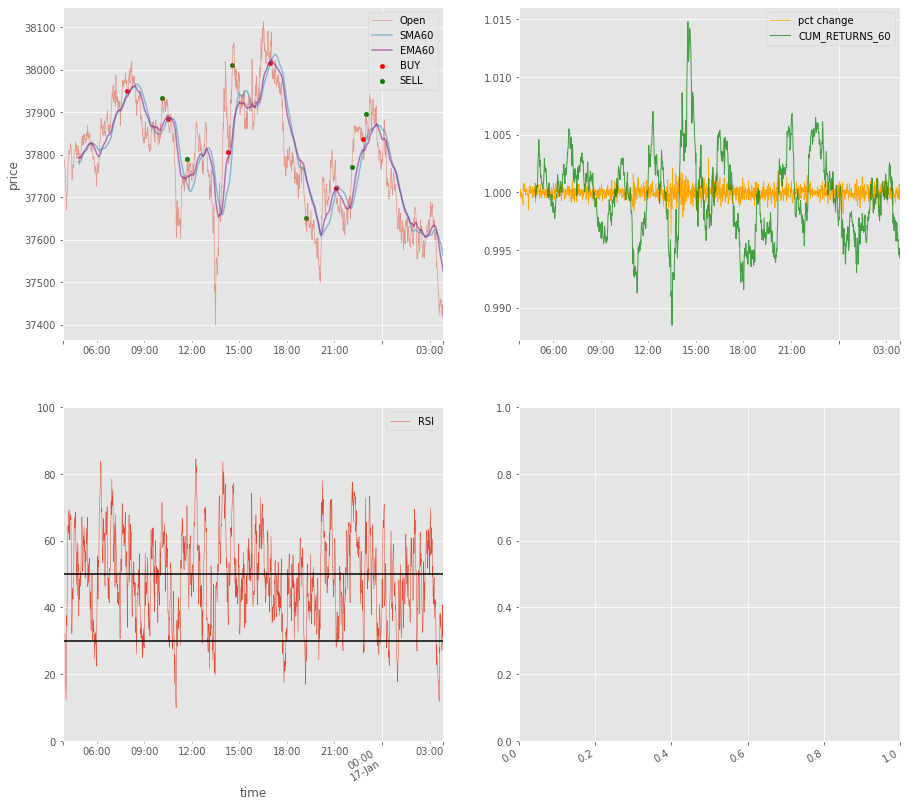

In [11]:
df = getminutedata("BTC-EUR", interval_min=1, lookback=60*24)
results = backtest(RSI_SMA_return_strategy, df)

## TRADING BOT

In [12]:
def main(strategy, capital, product_id="BTC-EUR", running_time = 60*2, entried = False, cancel_time=30):
    '''
    Main to run the trading bot
    
    Parameters
    ----------
    
    strategy: func
         function that returns "BUY", "SELL", "NO TRADE"
    
    capital: float
        the starting capital to start the trading bot
        
    product_id: str
        string of the currency you want to trade
    
    running_time: float
        amount of time you want to run the trading bot given in minutes
        
    entried: boolean
        whether we are already entried or not
    
    cancel_time: float
        time we can wait before we cancel a buy/sell order in minutes
    
    Returns
    -------
    
    df_trades: DataFrame
        a DataFrame containing the trades that have taken place in the running time
    
    '''
    start_time = time()
    entried_time = -1
    unentried_time = -1
    buy_order = {"status": None}
    sell_order = {"status": "done"}
    last_buying_price = -1
    columns = ["Buy date", "Buy price", "Sell date", "Sell price", "Start capital", "End capital", "Return", "Size", "Product ID", "Buy ID", "Sell ID"]
    df_trades = pd.DataFrame(columns=columns)
    

    # check the running time
    while (time()-start_time)/60 < running_time:
        try:

            df = getminutedata(product_id, interval_min=1, lookback=60*2)
            row = df.iloc[-1,:].copy()
            row["last_buying_price"] = last_buying_price
            action = strategy(row, entried=entried)
            current_time = pd.to_datetime(time(), unit="s").strftime("%Y-%m-%d %H:%M")
            print("Time: %s, Entried: %s, Action: %s" % (str(current_time), entried, action))
            
            # a product has been bought and sold if...
            if buy_order["status"]=="done" and sell_order["status"]=="done":
                
                trade = { "Buy date": buy_time
                        , "Buy price": buy_price
                        , "Buy ID": buy_order["ID"]
                        , "Sell date": sell_time
                        , "Sell price": sell_price
                        , "Sell ID": sell_order["ID"]
                        , "Start capital": buy_size*buy_price
                        , "End capital":  sell_size*sell_price
                        , "Return": (sell_price-buy_price)/buy_price
                        , "Size": sell_size
                        , "Product ID": product_id}
                df_trade = pd.DataFrame(columns=columns)
                df_trade = df_trade.append(trade, ignore_index=True)
                df_trade.to_csv("Trades.csv", mode="a", header=False)
                df_trades = df_trades.append(trade, ignore_index=True)
                
                
                
            # BUYING and SELLING:
            #---------------------------------------------------------------------------------------------------------------
            
            if entried == False: # try to buy 
                if action == "BUY" and sell_order["status"]=="done":
                    buy_time = pd.to_datetime(time(), unit="s").strftime("%Y-%m-%d %H:%M")
                    buy_price = round(row.Open*0.995, 2)
                    last_buying_price = buy_price
                    buy_size = round(capital/buy_price, 6)
                    buy_order = client.place_limit_order(product_id=product_id, side="buy", price=buy_price, size=buy_size)
                    entried = True
                    entried_time = time()
                    
                    # stats
                    print("Placed BUY order with the following details:")
                    print(buy_order)
                    print("\n")
                    
                # cancel SELL order when the cancel time is reached
                if (time()-unentried_time)/60 > cancel_time and sell_order["status"] != "done" and buy_order["status"] == "done":
                    print("Canceled SELL order with the following details:")
                    print(sell_order)
                    print("\n")
                    client.cancel_order(sell_order["id"])
                    entried = True            
        
            elif entried == True: # try to sell
                if action == "SELL" and buy_order["status"]=="done":
                    sell_time = pd.to_datetime(time(), unit="s").strftime("%Y-%m-%d %H:%M")
                    sell_price = round(row.Open, 2)
                    sell_size = round(buy_order["size"], 6)
                    sell_order = client.place_limit_order(product_id=product_id, side="sell", price=sell_price, size=sell_size)
                    unentried_time = time()
                    entried=False
                    capital = sell_price*sell_size*0.995 # factor 0.995 to ensure we have sufficient funds, since there are fees

                    # stats
                    print("Placed SELL order with the following details:")
                    print(sell_order)
                    print("\n")
                    
                # cancel BUY order when the cancel time is reached
                if (time()-entried_time)/60 > cancel_time and buy_order["status"] != "done" and sell_order["status"] == "done":
                    print("Canceled BUY order with the following details:")
                    print(buy_order)
                    print("\n")
                    client.cancel_order(buy_order["id"])
                    entried = False                   
                    
            #-------------------------------------------------------------------------------------------------------------------
                    
            sleep(60)



        except Exception as e:
            print("Time: %s, Entried: %s, Action: %s" % (str(current_time), entried, action))
            print("An error had occured: ")
            print(e)
            sleep(60)
            
    # out of the while loop so...
    if buy_order["status"] != "done":  # <==> == "open"
        client.cancel_order(buy_order["id"])
    if sell_order["status"] != "done":
        client.cancel_order(sell_order["id"])
        client.place_market_order(product_id, side="buy", size=sell_size)
    print("Reached end of the allowed running time")
    
    
    return df_trades
        

In [13]:
main(RSI_SMA_return_strategy, capital=90, running_time=60*10)

Time: 2022-01-17 03:51, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:52, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:53, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:54, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:55, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:56, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:57, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:58, Entried: False, Action: NO TRADE
Time: 2022-01-17 03:59, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:00, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:01, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:02, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:03, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:04, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:05, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:06, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:07, Entried: False, Action: NO TRADE
Time: 2022-01-17 04:08, Entried

,Buy date,Buy price,Sell date,Sell price,Start capital,End capital,Return,Size,Product ID,Buy ID,Sell ID


In [12]:
time()/60

27368128.18919653

In [28]:
with open("test.csv", "w") as f:
    f.write("hello")

In [30]:
with open("test.csv", "a") as f:
    f.write("\n")
    f.write("kek")

In [38]:
str(pd.to_datetime(time(), unit="s").strftime("%Y-%m-%d %H:%M"))

'2022-01-09 20:44'

In [60]:
df_trades = pd.DataFrame(columns=["Buy date", "Buy price", "Sell date", "Sell price", "Start capital", "End capital", "Return", "Size", "Product ID", "Buy ID", "Sell ID"])

In [61]:
df_trades.to_csv("Trades.csv", header=True)

In [62]:
trade = { "Buy date": 1
        , "Buy price":1
        , "Buy ID": 1
        , "Sell date": 1
        , "Sell price": 1
        , "Sell ID": 1
        , "Start capital":1
        , "End capital":  1
        , "Return": 1
        , "Size": 1
        , "Product ID": 1}

In [69]:
df_trades = df_trades.append(trade, ignore_index=True)

In [70]:
df_trades.to_csv("Trades.csv", header=True)

In [72]:
df_trades.to_csv("Trades.csv", mode="a", header=True)

In [1]:
a = { "Buy date": 1
    , "Buy price": 2
    , "Buy ID": 3
    , "Sell date": 4 
    , "Sell price": 4
    , "Sell ID": 5
    , "Return": 6}

In [21]:
b = pd.DataFrame(columns=a.keys())

In [23]:
b.append(a, ignore_index=True)

,Buy date,Buy price,Buy ID,Sell date,Sell price,Sell ID,Return
0,1,2,3,4,4,5,6


In [14]:
columns = ["Buy date", "Buy price", "Sell date", "Sell price", "Start capital", "End capital", "Return", "Size", "Product ID", "Buy ID", "Sell ID"]
df_trades = pd.DataFrame(columns=columns)

In [16]:
df_trades.to_csv("Trades.csv", header=True)

In [13]:
client.place_limit_order(product_id="BTC-EUR", side="buy", price=10, size=1)

{'id': '8feef794-7a36-4dc7-b53c-51dc833f8883',
 'price': '10',
 'size': '1',
 'product_id': 'BTC-EUR',
 'side': 'buy',
 'stp': 'dc',
 'type': 'limit',
 'time_in_force': 'GTC',
 'post_only': False,
 'created_at': '2022-01-13T15:42:02.531317Z',
 'fill_fees': '0',
 'filled_size': '0',
 'executed_value': '0',
 'status': 'pending',
 'settled': False}

In [15]:
client.get_order('8feef794-7a36-4dc7-b53c-51dc833f8883')

{'id': '8feef794-7a36-4dc7-b53c-51dc833f8883',
 'price': '10.00000000',
 'size': '1.00000000',
 'product_id': 'BTC-EUR',
 'profile_id': '2b41d297-6171-4a4b-b497-36f83147f5f7',
 'side': 'buy',
 'type': 'limit',
 'time_in_force': 'GTC',
 'post_only': False,
 'created_at': '2022-01-13T15:42:02.537288Z',
 'fill_fees': '0.0000000000000000',
 'filled_size': '0.00000000',
 'executed_value': '0.0000000000000000',
 'status': 'open',
 'settled': False}

In [16]:
client.cancel_order('8feef794-7a36-4dc7-b53c-51dc833f8883')

'8feef794-7a36-4dc7-b53c-51dc833f8883'

In [17]:
client.get_order('8feef794-7a36-4dc7-b53c-51dc833f8883')

{'message': 'NotFound'}

In [13]:
columns = ["Buy date", "Buy price", "Sell date", "Sell price", "Start capital", "End capital", "Return", "Size", "Product ID", "Buy ID", "Sell ID"]
df_trades = pd.DataFrame(columns=columns)
df_trades.to_csv("Trades_test.csv", header=True)

In [15]:
columns = ["Buy date", "Buy price", "Sell date", "Sell price", "Start capital", "End capital", "Return", "Size", "Product ID", "Buy ID", "Sell ID"]
trade = { "Buy date": 1
    , "Buy price": 1
    , "Buy ID": 1
    , "Sell date": 1
    , "Sell price": 1
    , "Sell ID": 1
    , "Start capital": 1
    , "End capital":  1
    , "Return": 2
    , "Size": 2
    , "Product ID": 3}
df_trade = pd.DataFrame(trade, columns=columns, ignore_index=True)
#df_trade = df_trade.append(trade, ignore_index=True)
#df_trade.to_csv("Trades_test.csv", mode="a", header=False)



TypeError: __init__() got an unexpected keyword argument 'ignore_index'

In [15]:
for i in range(2):
    print(i)

0
1


In [ ]:
df = 